In [32]:
import torch
from torchvision.datasets import FashionMNIST
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [33]:
train_input = fm_train.data
train_target = fm_train.targets
test_input = fm_test.data
test_target = fm_test.targets

In [34]:
train_input = train_input.reshape(-1,1,28,28)
test_input = test_input.reshape(-1,1,28,28)
train_scaled = train_input / 255.0
test_scaled = test_input / 255.0

In [35]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target
)

In [36]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1,32,kernel_size=3, padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(32,64,kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

In [37]:
model.add_module('dense1', nn.Linear(3136,100))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100,10))

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3136, out_features=100, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=100, out_features=10, bias=True)
)

In [39]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [40]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
erly_stopping_count = 0
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    model.eval()
    
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f'에포크 {epoch+1}/{epochs}, 훈련손실: {train_loss:.4f}, 검증손실: {val_loss:.4f}')
    if best_loss < 0 or val_loss < best_loss:
        best_loss = val_loss
        erly_stopping_count = 0
    else:
        erly_stopping_count += 1
        if erly_stopping_count >= patience:
            print('조기종료')
            break

에포크 1/20, 훈련손실: 0.4552, 검증손실: 0.3109
에포크 2/20, 훈련손실: 0.3015, 검증손실: 0.2826
에포크 3/20, 훈련손실: 0.2597, 검증손실: 0.2821
에포크 4/20, 훈련손실: 0.2305, 검증손실: 0.2502
에포크 5/20, 훈련손실: 0.2096, 검증손실: 0.2475
에포크 6/20, 훈련손실: 0.1889, 검증손실: 0.2563
에포크 7/20, 훈련손실: 0.1746, 검증손실: 0.2476
조기종료


TypeError: save() got an unexpected keyword argument 'weights_only'

In [42]:
torch.save(model.state_dict(), 'best_cnn_model.pt')

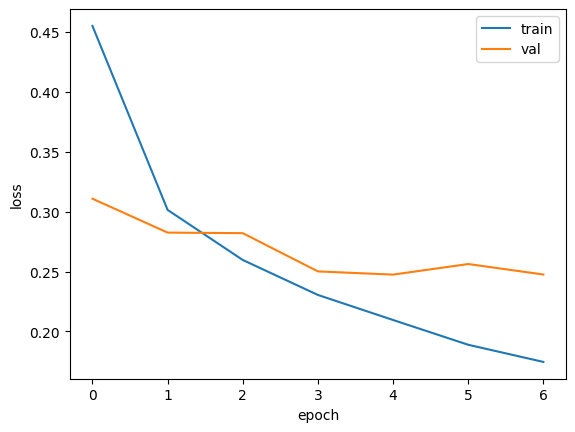

In [53]:
import matplotlib.pyplot as plt
        
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [43]:
model.load_state_dict(torch.load('best_cnn_model.pt', weights_only=True))

<All keys matched successfully>

In [55]:
model.eval()
corrects = 0
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()
        loss = criterion(outputs,targets)
        val_loss += loss.item()
acciracy = corrects / len(val_dataset)        
val_loss /= len(val_loader)
print(f'검증 정확도: {acciracy:.4f}\n검증 로스: {val_loss:.4f} ')

검증 정확도: 0.9141
검증 로스: 0.2476 
